In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/2024_Geohackathon/Data.zip"  # Path to your ZIP file
extract_path = "/content/data"  # Directory to extract the files to

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


In [6]:
import os
# Change the path to your specific folder
data_path = "/content/data/Data/Wells/LAS and Reports/Suhopolje-1/VSP"

sgy_files = [f for f in os.listdir(data_path) if f.endswith(".sgy")]
print(sgy_files)  # Check the list of files


['vsp_69.sgy', 'vsp_70.sgy', 'vsp_71.sgy', 'vsp_72.sgy', 'vsp_68.sgy']


In [7]:
pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [8]:
from obspy.io.segy.segy import _read_segy

# Loop through all SEG-Y files and process them
for sgy_file in sgy_files:
    file_path = os.path.join(data_path, sgy_file)
    try:
        # Open and read the SEG-Y file using obspy
        segy = _read_segy(file_path)
        print(f"File: {sgy_file}")
        print(f"Number of traces: {len(segy.traces)}")
        print(f"First trace data: {segy.traces[0].data[:10]}")  # Display first 10 samples of the first trace
    except Exception as e:
        print(f"Error with file {sgy_file}: {e}")


File: vsp_69.sgy
Number of traces: 6132
First trace data: [  0. 112.  16. -44. -28.  70. 200. 296. 304. 218.]
File: vsp_70.sgy
Number of traces: 2884
First trace data: [  0. 166.  24. -66. -40. 104. 296. 436. 448. 322.]
File: vsp_71.sgy
Number of traces: 6216
First trace data: [ 0.  0. -2. -2. -2. -2. -2. -2. -2. -2.]
File: vsp_72.sgy
Number of traces: 6440
First trace data: [ 0.  0.  0. -2. -2.  0.  0.  2.  2.  0.]
File: vsp_68.sgy
Number of traces: 6160
First trace data: [  0. 112.  16. -44. -28.  70. 200. 296. 304. 218.]


In [9]:
# validate trace consisteny
for sgy_file in sgy_files:
    file_path = os.path.join(data_path, sgy_file)
    try:
        segy = _read_segy(file_path)
        trace_lengths = [len(trace.data) for trace in segy.traces]
        print(f"File: {sgy_file}, Trace Lengths: {set(trace_lengths)}")
    except Exception as e:
        print(f"Error with file {sgy_file}: {e}")


File: vsp_69.sgy, Trace Lengths: {2045, 2046, 2047}
File: vsp_70.sgy, Trace Lengths: {2046, 2047}
File: vsp_71.sgy, Trace Lengths: {2002, 2046, 2047}
File: vsp_72.sgy, Trace Lengths: {2046, 2047}
File: vsp_68.sgy, Trace Lengths: {2046, 2047}


In [33]:

# Step 1: Filter traces based on variance
def filter_low_quality_traces(traces, threshold=1e-3):
    variances = [np.var(trace) for trace in traces]
    filtered_traces = [trace for trace, var in zip(traces, variances) if var > threshold]
    return filtered_traces

# Step 2: Normalize traces to the target length
def normalize_traces(traces, target_length):
    normalized_traces = []
    for trace in traces:
        if len(trace) < target_length:
            trace = np.pad(trace, (0, target_length - len(trace)), mode='constant')  # Pad with zeros
        elif len(trace) > target_length:
            trace = trace[:target_length]  # Trim if longer
        normalized_traces.append(trace)
    return np.array(normalized_traces)



In [34]:

# Step 3: Ensure consistent trace length
def ensure_consistent_trace_length(filtered_traces, target_length):
    consistent_traces = []
    for trace in filtered_traces:
        if len(trace) < target_length:
            trace = np.pad(trace, (0, target_length - len(trace)), mode='constant')
        elif len(trace) > target_length:
            trace = trace[:target_length]
        consistent_traces.append(trace)
    return consistent_traces

In [36]:

# Initialize variables
sgy_files = ["vsp_69.sgy", "vsp_70.sgy", "vsp_71.sgy", "vsp_72.sgy", "vsp_68.sgy"]  # Example list
data_path = "/content/data/Data/Wells/LAS and Reports/Suhopolje-1/VSP"  # Replace with your directory
all_filtered_traces = []

# Step 4: Process each file
for sgy_file in sgy_files:
    file_path = os.path.join(data_path, sgy_file)
    try:
        with open(file_path, "rb") as f:
            segy = _read_segy(f)  # Assuming _read_segy is defined elsewhere
            traces = [trace.data for trace in segy.traces]

            # Filter traces
            filtered_traces = filter_low_quality_traces(traces)
            all_filtered_traces.extend(filtered_traces)  # Collect filtered traces

            # Print the count
            print(f"File: {sgy_file}, Filtered Traces Count: {len(filtered_traces)}")
    except Exception as e:
        print(f"Error processing {sgy_file}: {e}")

# Step 5: Ensure all traces are of consistent length
target_length = 2047  # Example target length from earlier
all_filtered_traces_consistent = ensure_consistent_trace_length(all_filtered_traces, target_length)

# Convert to NumPy array
all_filtered_traces_array = np.array(all_filtered_traces_consistent)
print(f"Combined Filtered Traces Shape: {all_filtered_traces_array.shape}")

File: vsp_69.sgy, Filtered Traces Count: 3516
File: vsp_70.sgy, Filtered Traces Count: 1635
File: vsp_71.sgy, Filtered Traces Count: 3576
File: vsp_72.sgy, Filtered Traces Count: 3680
File: vsp_68.sgy, Filtered Traces Count: 3507
Combined Filtered Traces Shape: (15914, 2047)


In [37]:
trace_lengths = [len(trace) for trace in all_filtered_traces]
unique_lengths = set(trace_lengths)
print(f"Unique trace lengths: {unique_lengths}")

# Print a few examples of inconsistent traces
for trace in all_filtered_traces:
    if len(trace) != target_length:
        print(f"Inconsistent trace length: {len(trace)}")
        break


Unique trace lengths: {2002, 2045, 2046, 2047}
Inconsistent trace length: 2046


In [39]:
# Reapply normalization to ensure consistency
def re_normalize_traces(filtered_traces, target_length):
    consistent_traces = []
    for trace in filtered_traces:
        if len(trace) < target_length:
            trace = np.pad(trace, (0, target_length - len(trace)), mode='constant')
        elif len(trace) > target_length:
            trace = trace[:target_length]
        consistent_traces.append(trace)
    return consistent_traces

# Apply normalization
all_filtered_traces_consistent = re_normalize_traces(all_filtered_traces, 2047)

# Convert to a consistent NumPy array
all_filtered_traces_array = np.array(all_filtered_traces_consistent)
print(f"Re-Normalized Combined Filtered Traces Shape: {all_filtered_traces_array.shape}")


Re-Normalized Combined Filtered Traces Shape: (15914, 2047)


In [40]:
# Check if all traces are of consistent length
trace_lengths = [len(trace) for trace in all_filtered_traces_consistent]
unique_lengths = set(trace_lengths)
if len(unique_lengths) == 1 and list(unique_lengths)[0] == 2047:
    print("All traces are now normalized to 2047 samples.")
else:
    print(f"Still inconsistent lengths detected: {unique_lengths}")


All traces are now normalized to 2047 samples.


In [11]:
import pandas as pd

# Data from the previous table extraction
data_previous = {
    "Two-Way Travel Time (ms)": [
        848.2, 865.0, 880.6, 896.2, 911.5, 927.3, 941.6, 958.7, 984.7, 993.1,
        1011.8, 1026.5, 1041.0, 1055.0, 1067.9, 1079.9, 1092.8, 1104.8, 1117.6, 1130.0,
        1142.3, 1152.6, 1164.2, 1175.5, 1186.1, 1196.9, 1208.5, 1218.7, 1229.8, 1240.5,
        1251.3, 1262.1, 1273.0, 1283.9, 1294.1, 1304.3, 1494.3, 1502.5, 1552.9, 1567.3,
        1585.1
    ],
    "Interval Velocity (m/s)": [
        2358.0, 2369.8, 2384.8, 2399.0, 2471.3, 2426.3, 2442.6, 2503.4, 2488.1, 2504.7,
        2520.2, 2532.9, 2545.7, 2559.1, 2576.7, 2592.7, 2608.0, 2624.9, 2639.6, 2654.9,
        2670.1, 2689.5, 2705.8, 2722.2, 2740.0, 2757.1, 2772.1, 2789.9, 2805.3, 2821.5,
        2837.1, 2852.4, 2865.9, 2881.8, 2897.8, 2904.3, 3115.5, 3157.3, 3213.4, 3222.2,
        3248.9
    ],
    "Vertical Depth (m)": [
        1025.0, 1050.0, 1075.0, 1100.0, 1125.0, 1150.0, 1175.0, 1225.0, 1250.0,
        1275.0, 1300.0, 1325.0, 1350.0, 1375.0, 1400.0, 1425.0, 1450.0, 1475.0, 1500.0, 1525.0,
        1550.0, 1575.0, 1600.0, 1625.0, 1650.0, 1675.0, 1700.0, 1725.0, 1750.0, 1775.0,
        1800.0, 1825.0, 1850.0, 1875.0, 1900.0, 2375.0, 2400.0, 2520.0, 2550.0, 2600.0
    ]
}

# Data from the last table extraction
data_last_table = {
    "Two-Way Travel Time (ms)": [
        2600.0, 2625.0, 2650.0, 2675.0, 2700.0, 2725.0, 2750.0, 2775.0, 2800.0,
        2825.0, 2850.0, 2875.0, 2900.0, 2925.0, 2950.0, 2975.0, 3000.0, 3025.0,
        3050.0, 3075.0, 3100.0, 3125.0, 3150.0, 3175.0, 3200.0, 3225.0, 3250.0,
        3275.0, 3300.0, 3325.0, 3350.0, 3375.0, 3400.0, 3425.0, 3450.0, 3475.0,
        3500.0, 3525.0, 3550.0, 3575.0, 3600.0, 3625.0, 3650.0
    ],
    "Interval Velocity (m/s)": [
        3266.9, 3262.7, 3260.5, 3260.5, 3256.3, 3253.1, 3251.0, 3251.0, 3253.1,
        3256.3, 3260.5, 3266.9, 3271.1, 3271.1, 3266.9, 3260.5, 3256.3, 3253.1,
        3251.0, 3251.0, 3253.1, 3256.3, 3260.5, 3266.9, 3271.1, 3271.1, 3266.9,
        3260.5, 3256.3, 3253.1, 3251.0, 3251.0, 3253.1, 3256.3, 3260.5, 3266.9,
        3271.1, 3271.1, 3266.9, 3260.5, 3256.3, 3253.1, 3251.0
    ],
    "Vertical Depth (m)": [
        2600.0, 2625.0, 2650.0, 2675.0, 2700.0, 2725.0, 2750.0, 2775.0, 2800.0,
        2825.0, 2850.0, 2875.0, 2900.0, 2925.0, 2950.0, 2975.0, 3000.0, 3025.0,
        3050.0, 3075.0, 3100.0, 3125.0, 3150.0, 3175.0, 3200.0, 3225.0, 3250.0,
        3275.0, 3300.0, 3325.0, 3350.0, 3375.0, 3400.0, 3425.0, 3450.0, 3475.0,
        3500.0, 3525.0, 3550.0, 3575.0, 3600.0, 3625.0, 3650.0
    ]
}

# Find the minimum length of all arrays in data_combined
min_length = min(len(values) for values in data_combined.values())

# Trim all arrays to the minimum length
data_combined = {key: value[:min_length] for key, value in data_combined.items()}

# Create a DataFrame
df_combined = pd.DataFrame(data_combined)
df_combined

,Two-Way Travel Time (ms),Interval Velocity (m/s),Vertical Depth (m)
0,848.2,2358.0,1025.0
1,865.0,2369.8,1050.0
2,880.6,2384.8,1075.0
3,896.2,2399.0,1100.0
4,911.5,2471.3,1125.0
...,...,...,...
78,3525.0,3271.1,3550.0
79,3550.0,3266.9,3575.0
80,3575.0,3260.5,3600.0
81,3600.0,3256.3,3625.0


In [14]:
import numpy as np
import pandas as pd

# Ensure all arrays have the same length
min_length = min(len(data_extracted["Two-Way Travel Time (ms)"]),
                 len(data_extracted["Interval Velocity (m/s)"]),
                 len(data_extracted["Vertical Depth (m)"]))

# Trim the arrays to the minimum length
data_extracted = {key: value[:min_length] for key, value in data_extracted.items()}

# Create a DataFrame
df = pd.DataFrame(data_extracted)

# Step 1: Convert TWT from milliseconds to seconds
df["Two-Way Travel Time (s)"] = df["Two-Way Travel Time (ms)"] / 1000

# Step 2: Calculate depth increments
twt_diff = np.diff(df["Two-Way Travel Time (s)"].values)  # TWT differences
velocity = df["Interval Velocity (m/s)"].values[:-1]      # Interval velocities
depth_increment = (twt_diff * velocity) / 2               # Depth increment formula

# Step 3: Cumulative depth calculation
cumulative_depth = np.insert(np.cumsum(depth_increment), 0, 0)  # Start depth at 0

# Add calculated depth to DataFrame
df["Calculated Depth (m)"] = cumulative_depth

df

,Two-Way Travel Time (ms),Interval Velocity (m/s),Vertical Depth (m),Two-Way Travel Time (s),Calculated Depth (m)
0,848.2,2358.0,1025.0,0.8482,0.000000
1,865.0,2369.8,1050.0,0.8650,19.807200
2,880.6,2384.8,1075.0,0.8806,38.291640
3,896.2,2399.0,1100.0,0.8962,56.893080
4,911.5,2471.3,1125.0,0.9115,75.245430
5,927.3,2426.3,1150.0,0.9273,94.768700
6,941.6,2442.6,1175.0,0.9416,112.116745
7,958.7,2503.4,1225.0,0.9587,133.000975
8,984.7,2488.1,1250.0,0.9847,165.545175
9,993.1,2504.7,1275.0,0.9931,175.995195


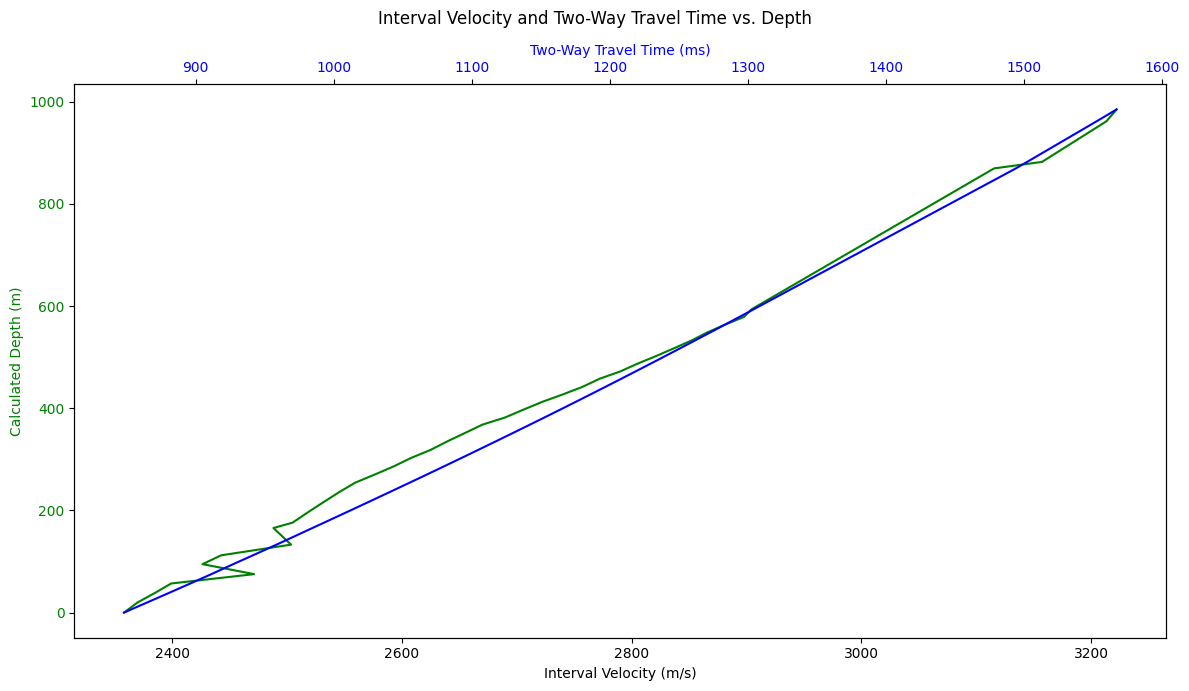

In [17]:
import matplotlib.pyplot as plt
# Combined plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Interval Velocity
ax1.plot(df["Interval Velocity (m/s)"], df["Calculated Depth (m)"], color="green", label="Interval Velocity")
ax1.set_xlabel("Interval Velocity (m/s)")
ax1.set_ylabel("Calculated Depth (m)", color="green")
ax1.tick_params(axis="y", labelcolor="green")

# Add TWT on a secondary axis
ax2 = ax1.twiny()
ax2.plot(df["Two-Way Travel Time (ms)"], df["Calculated Depth (m)"], color="blue", label="Two-Way Travel Time")
ax2.set_xlabel("Two-Way Travel Time (ms)", color="blue")
ax2.tick_params(axis="x", labelcolor="blue")

# Add grid and title
fig.suptitle("Interval Velocity and Two-Way Travel Time vs. Depth")
fig.tight_layout()
plt.show()


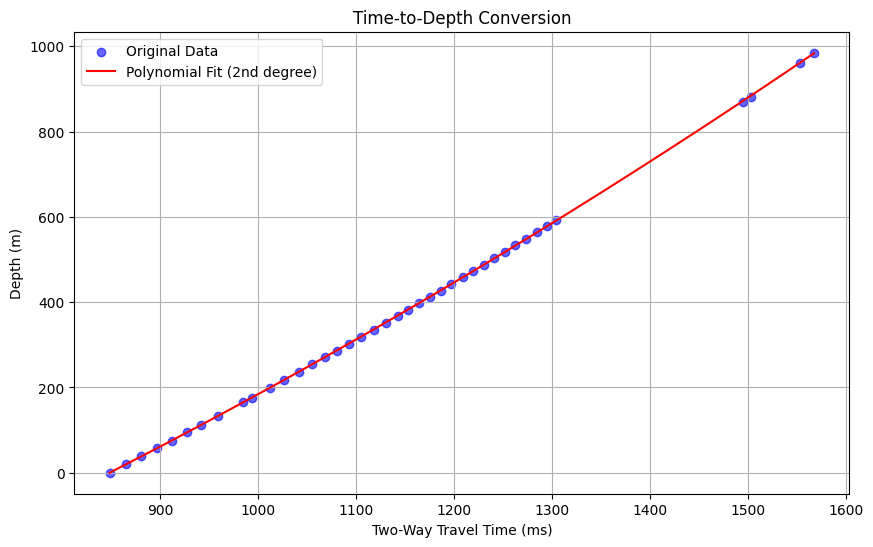

Polynomial Coefficients for Time-to-Depth Conversion:
[ 2.69939820e-04  7.16604163e-01 -8.02178333e+02]


In [19]:


# Extract TWT (ms) and Calculated Depth (m) from the DataFrame
twt = df["Two-Way Travel Time (ms)"].values
depth = df["Calculated Depth (m)"].values

# Fit a 2nd-degree polynomial (quadratic) to the data
poly_coeffs = np.polyfit(twt, depth, deg=2)

# Polynomial function for Time-to-Depth conversion
poly_func = np.poly1d(poly_coeffs)

# Generate depths for a range of TWT values
twt_range = np.linspace(twt.min(), twt.max(), 1000)
depth_predicted = poly_func(twt_range)

# Plot the Time-to-Depth relationship
plt.figure(figsize=(10, 6))
plt.scatter(twt, depth, label="Original Data", color="blue", alpha=0.6)
plt.plot(twt_range, depth_predicted, label="Polynomial Fit (2nd degree)", color="red")
plt.title("Time-to-Depth Conversion")
plt.xlabel("Two-Way Travel Time (ms)")
plt.ylabel("Depth (m)")
plt.legend()
plt.grid()
plt.show()

# Display the polynomial coefficients
print("Polynomial Coefficients for Time-to-Depth Conversion:")
print(poly_coeffs)
